In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
# Install packages
%pip install -U scikit-learn
%pip install ftfy
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports

import os

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from ftfy import fix_text
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Attach Google Drive for reading and saving files

# prj_path = '/home/mlworker/Quang/HealthCare/Source_14012023_v4/'
# data_path = prj_path + "data/"
# prj_path_opt= prj_path + "optimize_hyperparam/opt_results/opt_results_12022023_v4/"
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"

# Create Dict data for all cities

In [5]:
cities = [ 
# 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
#         'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
#         'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
#         'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
#         'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
#         'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
#          'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]

def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    # Đoạn này rất quan trọng. Vì việc optimize không được đụng vào 24 tháng (2016-2017) để dự báo. 
    # Dữ liệu optimize tính từ 1997- 30/12/2015. Sau đó tách ra train và test trên bộ này.
    # lọc 2 năm cuối ra khỏi bộ dữ liệu trước khi chạy optimize 
    # đoạn này áp dụng cho tất cả các bước optimize trong project
    city_result = city_result.loc[city_result['year_month'] < '2013-1-1'] 
    cities_data[city] = city_result
  return cities_data


dict_full_data = get_dict_all_city_data()

# Seeding

In [6]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

In [7]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        self.test_size = 24
        self.look_back = 3
        self.n_predicted_month = 3
        self.n_features = 3
        self.seed = 42
        self.batch_size = 16
        self.device = torch.device("cpu")
        self.epochs = 300

args = Configuration()

# Supporting functions

In [8]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases', 'province', 'year_month',
                                                        'Influenza_rates','Dengue_fever_rates',
                                                        'Influenza_cases','Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [9]:
def split_data(data):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]
    test = data[-args.test_size - args.look_back: ]
    return train, test

In [10]:
def to_supervised(data, d_in=args.look_back, d_out=args.n_predicted_month, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[in_end: out_end, -1])
    return np.array(X), np.array(y)

In [11]:
def select_feature(train, specific_data):
    """Selects args.n_features top features using RFE"""
    train_X, train_y = to_supervised(train, d_in=1, d_out=1)
    train_X, train_y = np.squeeze(train_X), np.squeeze(train_y)
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=args.seed), n_features_to_select=args.n_features)
    fit = rfe.fit(train_X, train_y)
    important_features = list()
    for i in range(len(fit.support_)):
        if fit.support_[i]:
            important_features.append(i)
    return np.array(important_features)

In [12]:
def get_data(train_np, test_np, batch_size, specific_data):
    """
    Returns important feature list and data formatted for input into Pytorch 
    models
    """
    important_features = select_feature(train_np, specific_data)
    print("🍤🍤🍤🍤🍤🍤🍤")
    print("important_features:",important_features)
    train_X, train_y = to_supervised(train_np, features_list=important_features)
    print("🦊🦊🦊🦊🦊🦊🦊🦊🦊🦊:")
    print("SHAPE train_X",train_X.shape)
    test_X, test_y = to_supervised(test_np, features_list=important_features)
    train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
    test_tensor = (torch.from_numpy(test_X), torch.from_numpy(test_y))

    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

    return important_features, train_loader, test_tensor

In [13]:
#Define Pytorch LSTM model
class MultiVariateLSTM(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = output[:, -1, :]
        y_predicted = self.linear(last_hidden_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            #return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

#Define Pytorch LSTM-ATT model
class MultiVariateLSTM_Attention(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.attention_linear = nn.Linear(hidden_size, hidden_size)
        # self.linear = nn.Linear(hidden_size*2, args.n_predicted_month)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = last_hidden[-1]
        remain_hidden_vector = output
        e_t = remain_hidden_vector.bmm(self.attention_linear(last_hidden_vector).unsqueeze(2)).squeeze(-1)
        alpha_t = F.softmax(e_t, dim=1)
        attenion_vector = remain_hidden_vector.transpose(2, 1).bmm(alpha_t.unsqueeze(2)).squeeze(-1)
        # combine_vector = torch.cat((last_hidden_vector, attenion_vector), dim=1)
        # combine_vector = last_hidden_vector + attenion_vector
        y_predicted = self.linear(attenion_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Define Pytorch CNN model
class MultivariateCNN(nn.Module):
    def __init__(self, num_filters=[100, 100, 100], dropout=0.01):
        super(MultivariateCNN, self).__init__()
        self.loss_fn = loss = nn.MSELoss()
        self.filter_sizes = [1, 2, 3]
        self.conv1d_list = nn.ModuleList([nn.Conv1d(args.n_features, num_filters[i], self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
        self.linear = nn.Linear(np.sum(num_filters), args.n_predicted_month)
        self.dropout = nn.Dropout(dropout)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))

    def forward(self, X_batch, y_batch=None):
        X_batch = X_batch.permute(0, 2, 1)  #(batch_size, n_features, n_look_back)
        print("🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:")
        print(X_batch.shape)
        X_conv_list = [F.relu(conv1d(X_batch)) for conv1d in self.conv1d_list]
        X_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in X_conv_list]
        X_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in X_pool_list], dim=1)
        y_predicted = self.linear(self.dropout(X_fc))
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted

    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

In [14]:
# Create class to train and evaluate models
class Trainer():
    def __init__(self, model_type, learning_rate, important_features, train_loader, test_tensor, n_layers=2, hidden_size=128, num_filters=[100, 100, 100], dropout=0.01):
        """
        Initialise trainer, allowing input of LSTM, LSTM-ATT, or CNN 
        hyperparameters. Adam optimiser used for all models.
        """
        self.model_type = model_type
        self.model = self.init_model(model_type, n_layers, hidden_size, num_filters, dropout)
        self.model.double().to(args.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.important_features, self.train_loader, self.test_tensor = important_features, train_loader, test_tensor
    
    def init_model(self, model_type, n_layers, hidden_size, num_filters, dropout):
        """Initialise a model based on whether LSTM, LSTM-ATT, or CNN is chosen."""
        if model_type.lower() == 'lstm':
            model = MultiVariateLSTM(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'lstm_attention':
            model = MultiVariateLSTM_Attention(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'cnn':
            model = MultivariateCNN(num_filters, dropout)
        return model

    def step(self, batch):
        self.model.train()
        X_batch, y_batch = tuple(t.to(args.device) for t in batch)
        self.optimizer.zero_grad()
        y_pred, loss = self.model.forward(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.mean().item()

    def validation(self):
        self.model.eval()
        eval_loss = 0.0

        result = {}

        y_true = np.array([])
        y_pred = np.array([])

        X_batch, y_batch = tuple(t.to(args.device) for t in self.test_tensor)
        with torch.no_grad():
            outputs, loss = self.model.forward(X_batch, y_batch)
            eval_loss = loss.mean().item()

        return eval_loss

    def train(self, epochs=20):
        best_lost = float("inf")
        best_model = None
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in self.train_loader:
                loss = self.step(batch)
                total_loss += loss
            train_loss = total_loss/len(self.train_loader)
            eval_loss = self.validation()
            if eval_loss < best_lost:
                best_lost = eval_loss
                best_model = copy.deepcopy(self.model)
            if (epoch + 1) == epochs or (epoch + 1) in [c + 1 for c in range(epochs) if c % int(epochs/4) == 0]:
                print(f"Epoch: {epoch:2}/{epochs:2} - train_loss: {train_loss:.4f} - test_loss: {eval_loss:4f}")
        self.model = best_model
        self.model.eval()
        return None
    
    def evaluate_model(self, np_data=None, plot=True, scaled=True, city=None, k_steps=None, y_scaler = None):
        assert scaled, "data must be scaled"
        self.model.eval()
        tensor_data = torch.from_numpy(np_data) # np_data = bộ dữ liệu đưa vào
        rmse_list = []
        mae_list = [] 
        mape_list = []

        y_predicted_list = []
        y_true_list = []

        print("🌽🌽🌽🌽🌽🌽🌽")
        print("important_features: ",self.important_features)
        print("np_data shape: ", np_data.shape)
        print("tensor_data shape: ", tensor_data.shape)
        for k_steps in range(1, args.n_predicted_month + 1):
            y_predicted = []
            y_true = []
            for index in range(tensor_data.size(0) - args.look_back):
                X = tensor_data[index: index + args.look_back, self.important_features]
                # yhat = self.model.predict(X.unsqueeze(0)).squeeze()

                yhat = self.model.predict(X.unsqueeze(0))
                yhat = yhat.squeeze()

                y_predicted.append(yhat.detach().cpu().numpy()[k_steps - 1])
                y_true.append(tensor_data[index + args.look_back, -1].detach().cpu().numpy())

            y_predicted = y_scaler.inverse_transform(np.array(y_predicted).reshape(-1, 1)).reshape(-1, )
            print("🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋")
            print("SHAPE y_predicted:", y_predicted.shape)
            print("y_predicted:", y_predicted)
            y_true = y_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).reshape(-1, )
            print("SHAPE y_true:", y_true.shape)
            print("y_true:", y_true)

            if plot==True:
                plt.plot(y_predicted, label='predicted')
                plt.plot(y_true, label='actual')
                plt.title(f"k-steps = {k_steps}")
                plt.legend()
                plt.show()

                plt.show()

            rmse = mean_squared_error(y_true, y_predicted, squared=False)
            mae = mean_absolute_error(y_true, y_predicted)
            mape = mean_absolute_percentage_error(y_true, y_predicted)

            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)

            y_predicted_list.append(y_predicted)
            y_true_list.append(y_true)

        return y_true_list, y_predicted_list, rmse_list, mae_list, mape_list

In [15]:
def concate_2_filter_str(listfilter = ''):
  string_filter = ','.join(str(e) for e in listfilter)
  return string_filter

# Objective and main run functions

In [16]:
def objective(trial, city):    
    # Define search parameters   
    args.epochs = trial.suggest_int('Epochs', 100, 500, step=10)
    learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
    num_filters = trial.suggest_categorical('Num. filters', [[64, 64, 64], [100, 100, 100], [128, 128, 128], [16, 32, 64], [32, 64, 128]])
    dropout = trial.suggest_uniform('Dropout rate', 0.01, 0.80)

    # Pre-process data
    specific_data = get_city_data(fix_text(city))
    specific_data = impute_missing_value(specific_data)
    specific_data = convert_to_stationary(specific_data)
    specific_data.dropna(inplace=True)
    train, test = split_data(specific_data)

    # Fit data scaler to training data
    full_scaler = MinMaxScaler().fit(train)
    y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))

    # Scale train and test data
    train = full_scaler.transform(train)
    test = full_scaler.transform(test)

    # Get data to run model
    important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, specific_data)

    # CNN model
    trainer = Trainer(model_type='cnn',
                  learning_rate=learning_rate,
                  important_features=important_features,
                  train_loader=train_loader,
                  test_tensor=test_tensor,
                  num_filters=num_filters, 
                  dropout=dropout)

    # Train model
    # trainer.train(epochs=args.epochs, trial=trial)
    trainer.train(epochs=args.epochs)

    
    # Evaluate model
    y_true, y_pred, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, plot= True, scaled=True, city=city, y_scaler = y_scaler)
    # _, _, rmse, mae, = trainer.evaluate_model(np_data=test, plot=False, scaled=True, city=city, y_scaler=y_scaler)

    return mae_list[0]    

[I 2023-11-08 00:40:57,448] A new study created in memory with name: no-name-51807894-1b7c-41d5-a657-827440be4df8
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64, 64] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 

🍭🍭🍭🍭🍭
🍒
🍤🍤🍤🍤🍤🍤🍤
important_features: [ 6 12 25]
🍤🍤🍤🍤🍤🍤🍤
important_features: [ 6 12 25]
🦊🦊🦊🦊🦊🦊🦊🦊🦊🦊:
SHAPE train_X (162, 3, 3)
🦊🦊🦊🦊🦊🦊🦊🦊🦊🦊:
SHAPE train_X (162, 3, 3)
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍤🍤🍤🍤🍤🍤🍤
important_features: [ 6 12 25]
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🦊🦊🦊🦊🦊🦊🦊🦊🦊🦊:
SHAPE train_X (162, 3, 3)
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
to

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3,

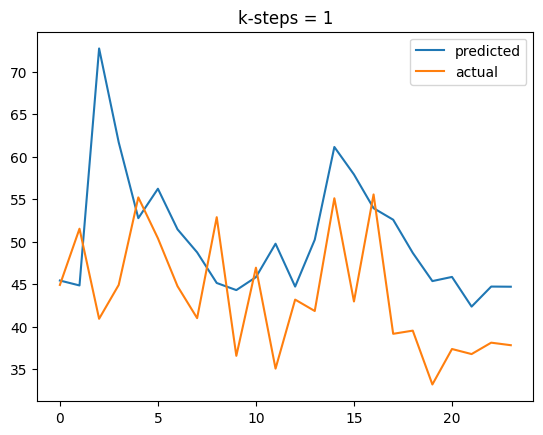

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [44.41016813 50.29612024 63.45423144 59.48220366 48.72767769 50.14644972
 45.41625571 44.23807322 41.95741303 41.24659569 46.07573945 45.69410287
 44.27641067 53.6537904  62.9059966  52.39067879 49.11913394 44.57534829
 43.13175157 44.90064517 40.77190521 37.05124589 43.52187769 42.98860838]
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.9

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


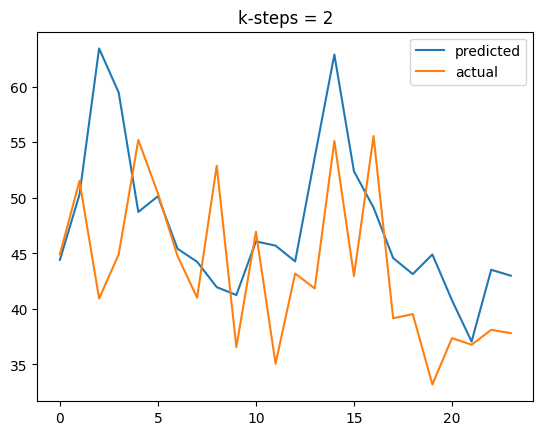

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [48.05971864 44.92420363 60.71834709 53.7565894  53.44041143 53.05642324
 50.43946722 47.41380579 46.18778466 48.32651988 46.67148102 56.13499233
 42.99528602 45.28820298 51.67867188 61.29420938 51.47543517 49.54614523
 49.08736521 48.63378247 53.80066905 40.81528556 42.09705144 50.94225362]
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.92379448 44.91085534 55.21703152 50.40246746
 44.76040021 40.99902204 52.88497706 36.5605958  46.94199955 35.05604453
 43.18317422 41.84069212 55.11634845 42.95942721 55.56384248 39.15572792
 39.52863962 33.18914081 37.36575179 36.76909308 38.11157518 37.81324582]
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHA

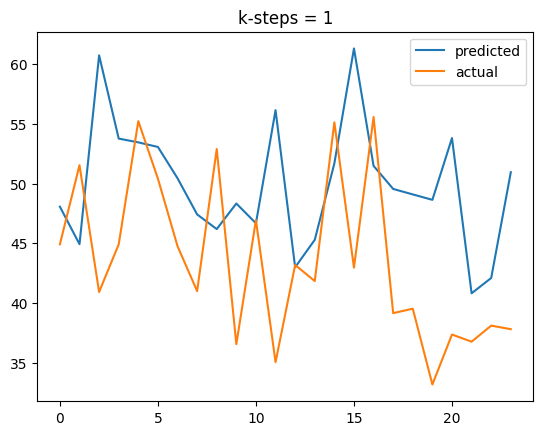

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


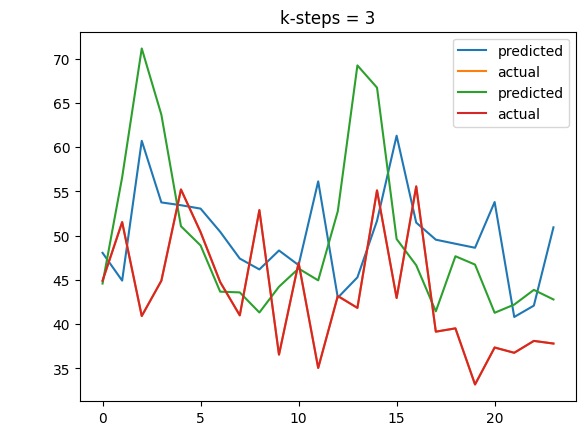

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
[I 2023-11-08 00:42:48,187] Trial 7 finished with value: 8.529786488272775 and parameters: {'Epochs': 360, 'Learning rate': 0.009360152425669632, 'Num. filters': [32, 64, 128], 'Dropout rate': 0.5601063311648367}. Best is trial 7 with value: 8.529786488272775.


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [41.65421061 44.27778443 62.84575802 49.82976088 42.70961084 46.4247177
 56.89390367 47.32293311 47.55937437 43.14544691 41.76976593 51.95753464
 34.20365506 44.51726679 61.8705814  52.49553405 46.77418555 50.00826809
 44.03458753 42.38346356 50.49864248 31.9000071  33.56086922 45.66817439]
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.92379448 44.91085534 55.21703152 50.40246746
 44.76040021 40.99902204 52.88497706 36.5605958  46.94199955 35.05604453
 43.18317422 41.84069212 55.11634845 42.95942721 55.56384248 39.15572792
 39.52863962 33.18914081 37.36575179 36.76909308 38.11157518 37.81324582]
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHA

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64, 64] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [100, 100, 100] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-pack

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


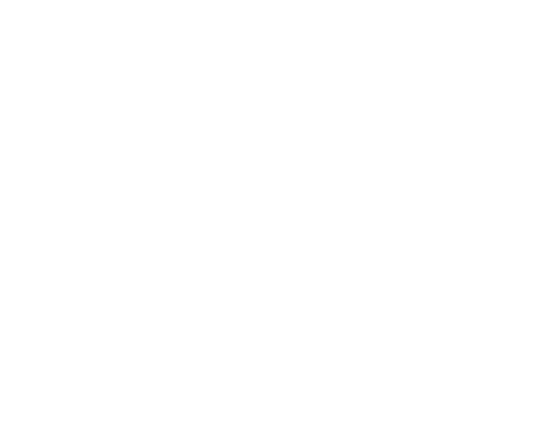

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
Epoch: 359/360 - train_loss: 0.1618 - test_loss: 0.155387
🌽🌽🌽🌽🌽🌽🌽
important_features:  [ 6 12 25]
np_data shape:  (27, 26)
tensor_data shape:  torch.Size([27, 26])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_ba

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

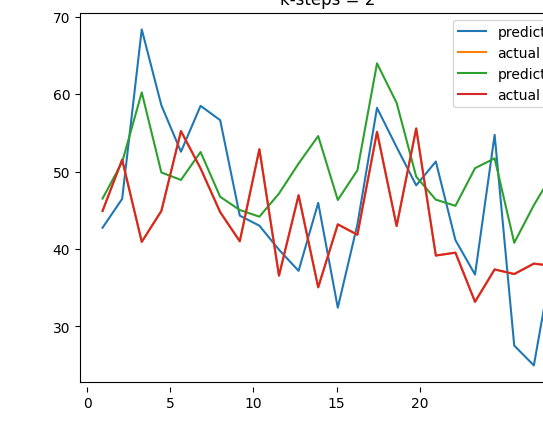

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

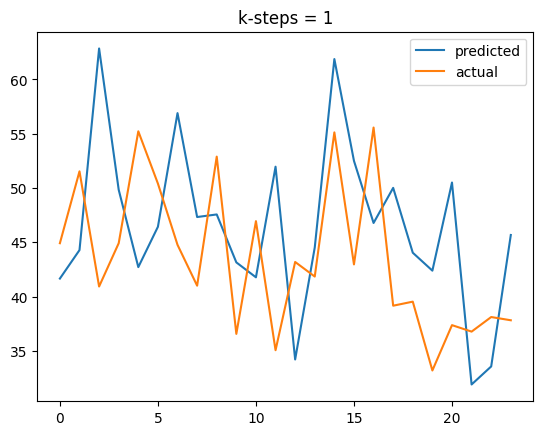

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [45.49250603 48.01688707 67.7202643  

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_pre

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [42.5240074  52.99817139 53.24924892 49.32767912 40.05962377 56.37937939
 53.401638   43.99553235 45.18306477 42.69185555 48.16622197 46.46736152
 40.74030818 42.6362763  67.9191422  58.66633978 51.52359147 53.52392405
 33.20439534 58.48091352 47.10483451 27.29252147 39.10846056 44.59812997]
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.9237

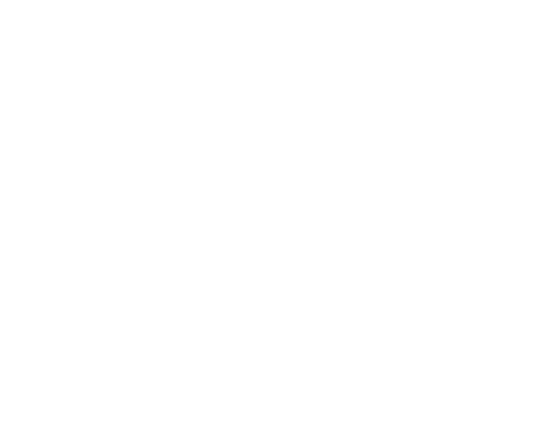

[I 2023-11-08 00:42:49,278] Trial 1 finished with value: 8.217436673839309 and parameters: {'Epochs': 500, 'Learning rate': 0.0011314231879803462, 'Num. filters': [16, 32, 64], 'Dropout rate': 0.5777353523636626}. Best is trial 1 with value: 8.217436673839309.


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64, 64] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [100, 100, 100] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-pack

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


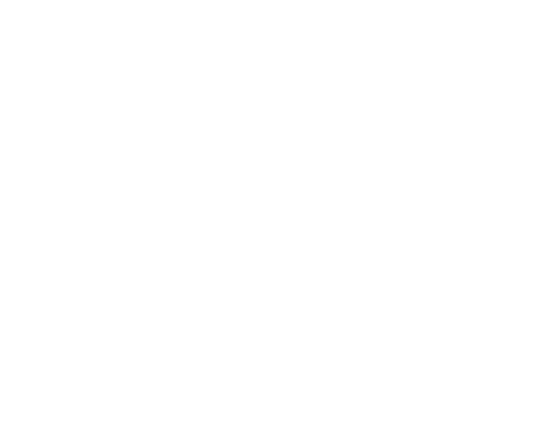

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

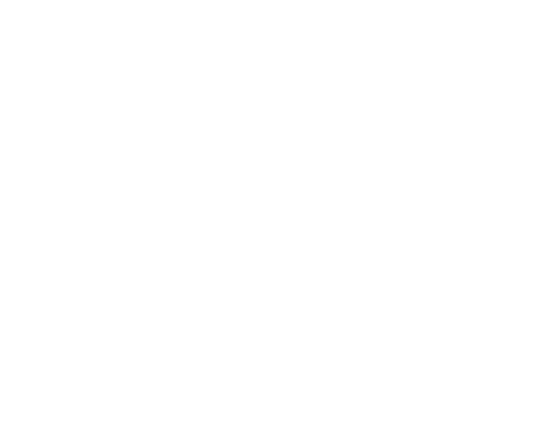

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_pred

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [38.05400325 79.41714546 81.55144917 48.38172799 45.67052568 48.06533831
 36.9137464  37.88378393 34.64988677 35.25125368 35.49767017 37.24664295
 49.72887402 67.57659742 47.79308533 45.69299202 36.15418695 31.19972259
 30.3516693  42.71397585 38.84831534 35.00234133 36.54104047 33.03215103]
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.92379448 44.91085534 55.21703152 50.40246746
 44.76040021 40.99902204 52.88497706 36.5605958  46.94199955 35.05604453
 43.18317422 41.84069212 55.11634845 42.95942721 55.56384248 39.1557

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

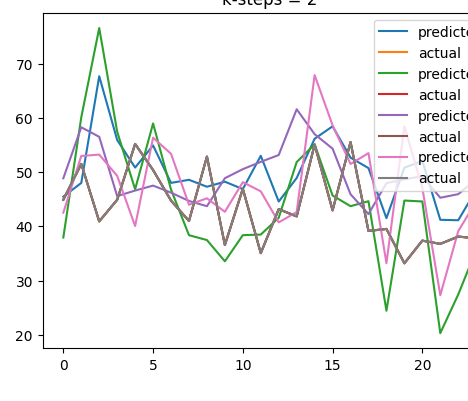

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2


torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

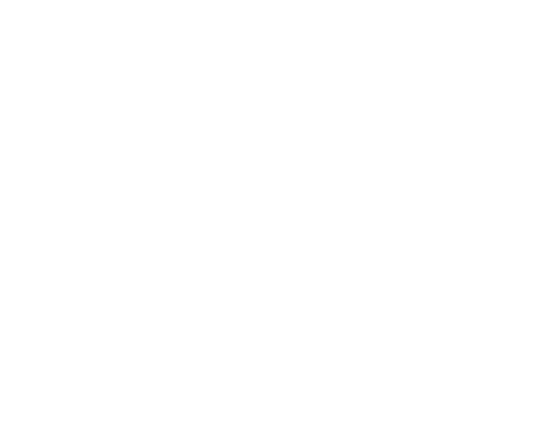

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])

torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

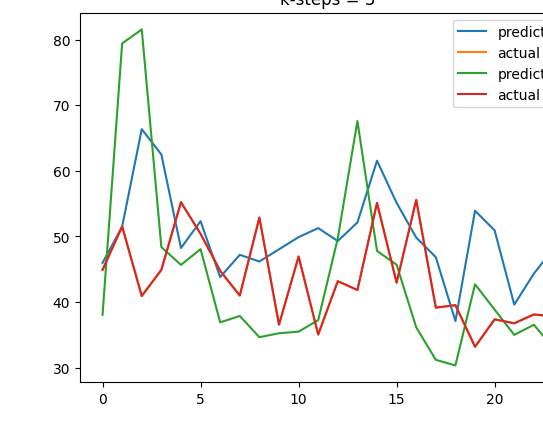

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64, 64] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [100, 100, 100] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-pack

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])

torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [45.51827648 69.88200565 57.48979136 42.82580972 45.36202617 50.49637477
 47.61602361 41.96469932 39.12104175 46.18738351 47.85696944 41.43534889
 50.64715502 64.83745624 56.92024313 55.1311405  49.43658965 45.19302363
 39.1457173  53.36868881 35.70232917 49.87221876 42.60456245 38.64661526]
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.92379448 44.91085534 55.21703152 50.40246746
 44.76040021 40.99902204 52.88497706 36.5605958  46.94199955 35.05604453
 43.18317422 41.84069212 55.11634845 42.95942721 55.56384248 39.15572792
 39.52863962 33.18914081 37.36575179 36.76909308 38.11157518 37.81324582]
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


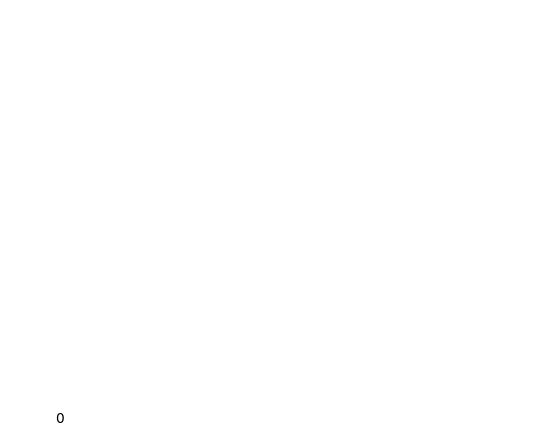

[I 2023-11-08 00:42:50,753] Trial 6 finished with value: 8.248911890815371 and parameters: {'Epochs': 440, 'Learning rate': 0.0003594210251371843, 'Num. filters': [32, 64, 128], 'Dropout rate': 0.10704053843334284}. Best is trial 1 with value: 8.217436673839309.
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64, 64] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:52

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
Epoch: 359/360 - train_loss: 0.1812 - test_loss: 0.150618
🌽🌽🌽🌽🌽🌽🌽
important_features:  [ 6 12 25]
np_data shape:  (27, 26)
tensor_data shape:  torch.Size([27, 26])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_bat

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [43.56761064 43.30264815 68.09426334 62.64646458 56.12250354 57.12964712
 57.63296528 46.00402415 45.74476422 47.21368234 42.67015621 51.11639676
 43.03108671 47.31551067 61.75852669 57.09941026 50.26090658 53.30193111
 44.81929092 47.82721348 52.12241853 33.5315224  39.09494332 46.95417733]
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.92379448 44.91085534 55.21703152 50.40246746
 44.76040021 40.99902204 52.88497706 36.5605958  46.94199955 35.05604453
 43.18317422 41.84069212 55.11634845 42.95942721 55.56384248 39.15572792
 39.52863962 33.18914081 37.36575179 36.76909308 38.11157518 37.81324582]


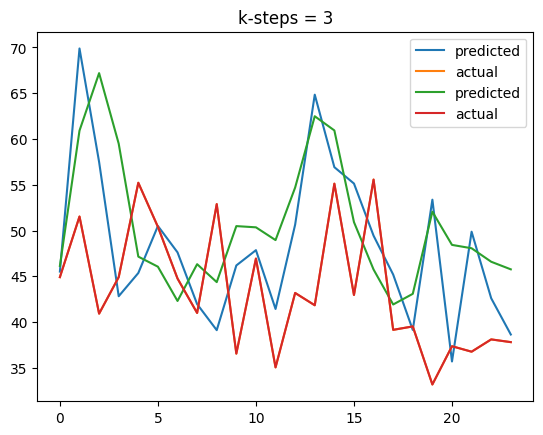

[I 2023-11-08 00:42:51,379] Trial 2 finished with value: 7.803270810950262 and parameters: {'Epochs': 100, 'Learning rate': 0.0010674946766412827, 'Num. filters': [16, 32, 64], 'Dropout rate': 0.6733832726750568}. Best is trial 2 with value: 7.803270810950262.
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64, 64] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524:

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])

torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


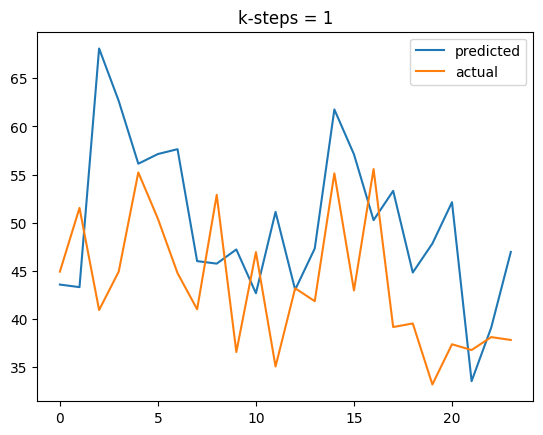

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [44.89395609 57.85276738 78.63387629 73.76731679 57.17331934 60.65949914
 50.68026907 45.66518013 45.55190759 45.35936443 46.25345286 49.28041956
 50.55466415 57.83286613 72

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


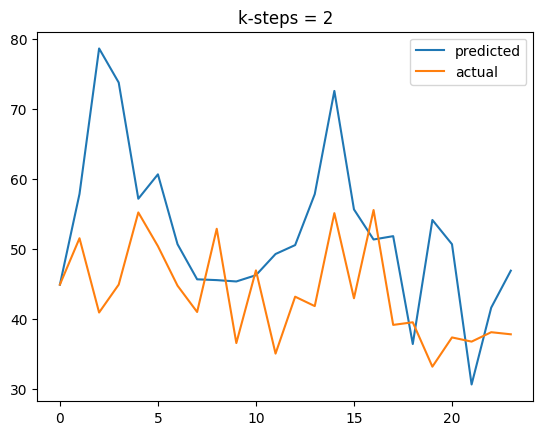

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
Epoch: 359/360 - train_loss: 0.1384 - test_loss: 0.134429
🌽🌽🌽🌽🌽🌽🌽
important_features:  [ 6 12 25]
np_data shape:  (27, 26)
tensor_data shape:  torch.Size([27, 26])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batc

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [46.18375115 68.9917702  77.39922549 64.88206187 52.14995635 49.77214894
 49.16775949 44.99902851 43.36346427 48.19100637 47.60356592 45.74156339
 58.86802544 71.99568297 72.07780161 52.10754806 46.58735926 43.46042922
 44.55581811 48.8273925  46.08860579 38.3720783  45.36200311 43.51221726]
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.92379448 44.91085534 55.21703152 50.40246746
 44.76040021 40.99902204 52.88497706 36.5605958  46.94

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


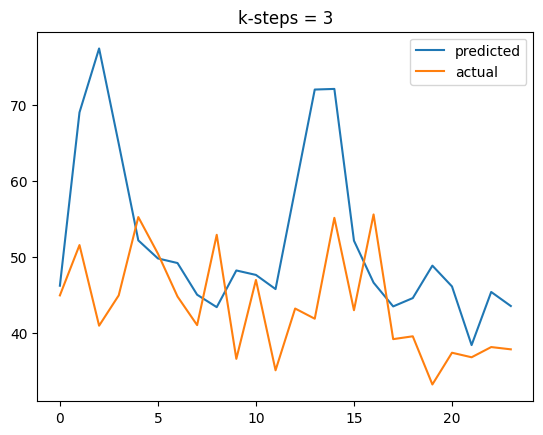

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
[I 2023-11-08 00:42:52,545] Trial 0 finished with value: 8.834114034796855 and parameters: {'Epochs': 500, 'Learning rate': 0.00017481690673306862, 'Num. filters': [64, 64, 64], 'Dropout rate': 0.3974943873298113}. Best is trial 2 with value: 7.803270810950262.
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packag

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋🍋
SHAPE y_predicted: (24,)
y_predicted: [43.43051368 46.86841247 67.52503596 58.92704395 55.34438396 56.22828581
 55.58283356 49.33381741 46.34234732 45.78759269 43.30940453 53.12863928
 43.3799294  48.54927926 48.25479085 57.85863606 52.76800832 53.74418928
 46.215416   44.85103825 50.2283759  36.90880439 35.21477334 45.01307956]
SHAPE y_true: (24,)
y_true: [44.91085534 51.53088091 40.92379448 44.91085534 55.21703152 50.40246746
 44.76040021 40.99902204 52.88497706 36.5605958  46.94199955 35.05604453
 43.18317422 41.84069212 55.11634845 42.95942721 55.56384248 39.15572792
 39.52863962 33.18914081 37.36575179 36.76909308 38.11157518 37.81324582]
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


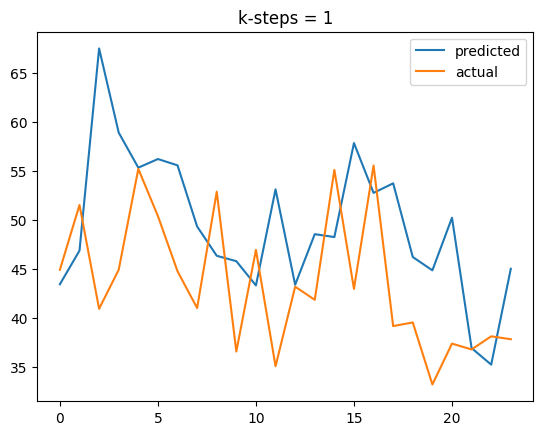

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])


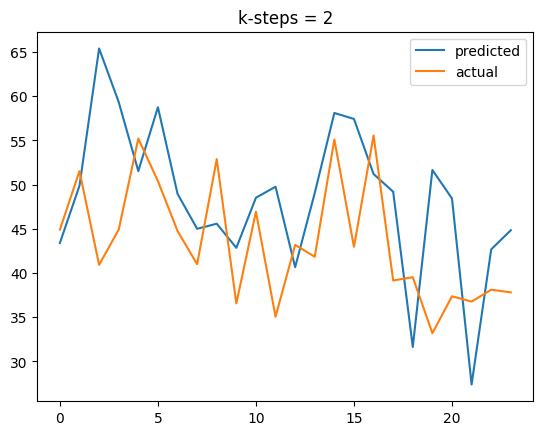

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


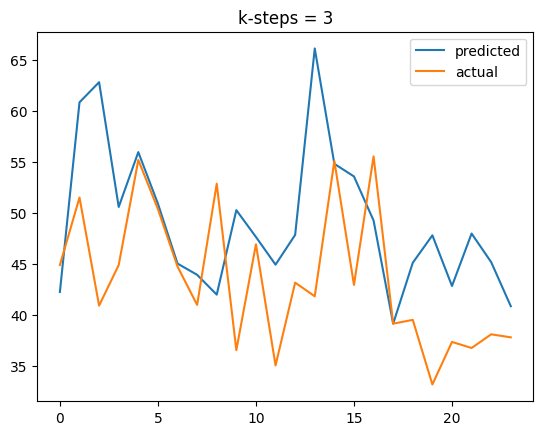

[I 2023-11-08 00:42:54,075] Trial 4 finished with value: 8.201812717228709 and parameters: {'Epochs': 360, 'Learning rate': 0.0005251145695392748, 'Num. filters': [32, 64, 128], 'Dropout rate': 0.39912140964796}. Best is trial 2 with value: 7.803270810950262.


🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])


/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64, 64] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [100, 100, 100] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-pack

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
Epoch: 359/360 - train_loss: 0.1141 - test_loss: 0.198479
🌽🌽🌽🌽🌽🌽🌽
important_features:  [ 6 12 25]
np_data shape:  (27, 26)
tensor_data shape:  torch.Size([27, 26])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHA

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

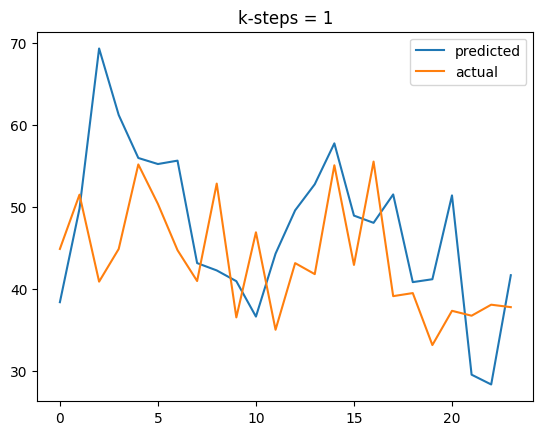

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SH

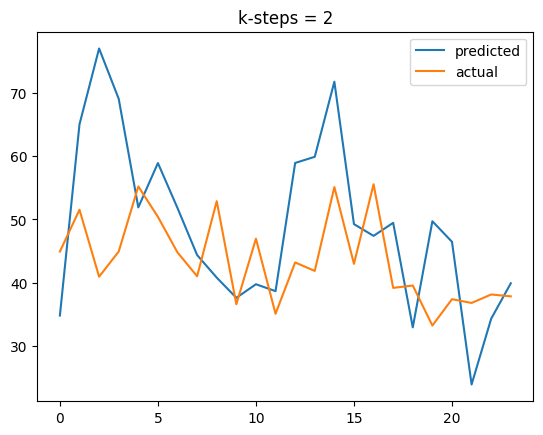

/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2077648992.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=args.device)
/var/folders/r_/lbw3rw192wl9sx9vtc1c2

🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([1, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SH

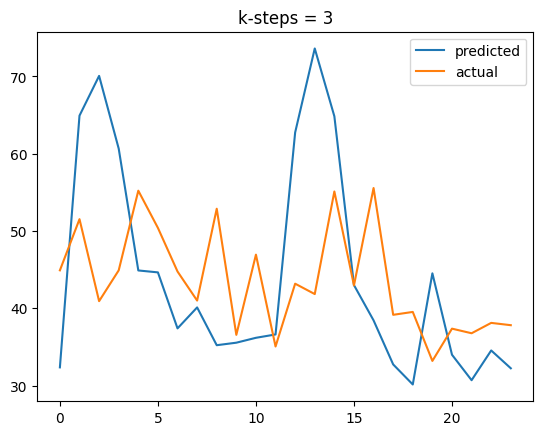

[I 2023-11-08 00:42:55,996] Trial 5 finished with value: 8.188034284724198 and parameters: {'Epochs': 150, 'Learning rate': 0.0029560258622871064, 'Num. filters': [128, 128, 128], 'Dropout rate': 0.20022591491808012}. Best is trial 2 with value: 7.803270810950262.
/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_74159/2929648913.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64, 64] which is of type list.
  warnings.warn(message)
/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/distributions.py:

🍤🍤🍤🍤🍤🍤🍤
important_features: [ 6 12 25]
🦊🦊🦊🦊🦊🦊🦊🦊🦊🦊:
SHAPE train_X (162, 3, 3)
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([2, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([22, 3, 3])
Epoch:  0/480 - train_loss: 0.7914 - test_loss: 0.721246
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 3, 3])
🙊🙊🙊🙊🙊🙊🙊🙊SHAPE X_batch:
torch.Size([16, 

: 

In [17]:
#########################
# Main Cell for optimize
#########################
dt_started = datetime.now()

# Input param for Optimize Run
ntry = 50
njob = -1


# Lưu thông tin traceback study và error city trong quá trình optimize
l_study_city ={}
l_errCity =[]
 

if __name__ == '__main__':  
#   best_param = pd.DataFrame()
  for city in cities:
    # Use Tree-structured Parzen Estimator sampler to minimise RMSE
    sampler = optuna.samplers.TPESampler()
    study = optuna.create_study(sampler=sampler, direction='minimize')

    # truyền multiple param vào trong biến trial
    obj_func = lambda trial: objective(trial, city)
    print("🍭🍭🍭🍭🍭")

    try:
      # Optimise over 100 trials
      print("🍒")
      study.optimize(obj_func, n_trials=ntry, n_jobs=njob)
      print("🫐")

      # Print results
      print("Study statistics for : ")
      print("  Number of finished trials: ", len(study.trials))
  
      
      print("Best trial of city: ",city)
      best_trial = study.best_trial
      print("  Value: ", best_trial.value)   

      # lưu best param vào trong biến toàn cục
      one_city_param = pd.DataFrame({                     
                              'City': city,
                              'Alg_name': 'cnn',
                              'Best_value': best_trial.value,
                              'n_try_opt': ntry,
                              'n Feature': 3, # dùng chung cho tất cả các model và algorithm
                              'Batch Size': 16, # dùng chung cho tất cả các model và algorithm
                              'Lookback Window': 3, # dùng chung cho tất cả các tỉnh của CNN
                              'Epochs': best_trial.params['Epochs'],
                              'Hiden Size': '', # CNN không quan tâm
                              'n Layers': '', # CNN không quan tâm
                              'Learning rate': best_trial.params['Learning rate'], 
                              'Num. filters': concate_2_filter_str(best_trial.params['Num. filters']), # đoạn này ép kiểu không sẽ thành x 3 do cấu trúc [] 
                              'Dropout rate': best_trial.params['Dropout rate']}, index=[0])
      display(one_city_param)
      # one_city_param.to_excel(prj_path_opt+'cnn/diarrhoea_opt_hyperparam_cnn_'+city+'.xlsx')
      best_param = best_param.append(one_city_param)
    except:# có error thì lưu vào l_errCity để check lại sau 
      l_errCity.append(city)
  # lưu kết quả vào file CNN
#   best_param.to_excel(prj_path_opt+'cnn/diarrhoea_opt_hyperparam_cnn.xlsx')

dt_ended = datetime.now()
print('kết thúc study trong:', round((dt_ended - dt_started).total_seconds()/60))

In [ ]:
# import requests

# def send_to_telegram(message):

#     apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
#     chatID = '@ptn_announcement'
#     apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

#     try:
#         response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
#         print(response.text)
#     except Exception as e:
#         print(e)

# send_to_telegram("Server Chạy test Xong CNN testsize=24" )